## Importing and splitting data

In [226]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import TargetEncoder, StandardScaler, OneHotEncoder, FunctionTransformer
from category_encoders import TargetEncoder as SafeTargetEncoder

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [227]:
df = pd.read_csv('BigBasket Products.csv', sep = ',')

In [228]:
# Separate data with missing ratings for later prediction
test_no_target = df[df['rating'].isnull()].copy()
df = df[df['rating'].notnull()].copy()

print("="*60)
print("DATA SEPARATION")
print("="*60)
print(f"Dataset with rating (df): {df.shape[0]} rows")
print(f"Dataset without rating (test_no_target): {test_no_target.shape[0]} rows")
print(f"Total: {df.shape[0] + test_no_target.shape[0]} rows")


DATA SEPARATION
Dataset with rating (df): 18929 rows
Dataset without rating (test_no_target): 8626 rows
Total: 27555 rows


In [229]:
# Split data into training (70%) and testing (30%)
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

print("="*60)
print("test-TEST SPLIT")
print("="*60)
print(f"Training set: {df_train.shape[0]} rows ({100*df_train.shape[0]/(df_train.shape[0]+df_test.shape[0]):.1f}%)")
print(f"Test set: {df_test.shape[0]} rows ({100*df_test.shape[0]/(df_train.shape[0]+df_test.shape[0]):.1f}%)")
print(f"Total: {df_train.shape[0] + df_test.shape[0]} rows")


test-TEST SPLIT
Training set: 13250 rows (70.0%)
Test set: 5679 rows (30.0%)
Total: 18929 rows


In [230]:
X_train = df_train.drop('rating', axis=1)
y_train = df_train['rating']
X_test = df_test.drop('rating', axis=1)
y_test = df_test['rating']

## EDA

In [231]:
len(df_train)

13250

In [232]:
df_train.describe()

,index,sale_price,market_price,rating
count,13250.000000,13250.000000,13250.000000,13250.000000
mean,13772.842491,266.976042,321.265427,3.943283
std,7978.002676,357.343034,448.298725,0.737681
min,2.000000,3.000000,3.000000,1.000000
25%,6791.500000,85.000000,95.000000,3.700000
50%,13778.500000,165.000000,199.000000,4.100000
75%,20690.250000,304.750000,370.000000,4.300000
max,27555.000000,6660.000000,7400.000000,5.000000


In [233]:
df_train.describe(include='object')

,product,category,sub_category,brand,type,description
count,13249,13250,13250,13250,13250,13190
unique,11806,9,76,1762,353,11136
top,Turmeric Powder/Arisina Pudi,Beauty & Hygiene,Skin Care,bb Royal,Face Care,"Energetic strong and stirred with action, X-ME..."
freq,19,3804,1148,192,762,27


In [234]:
df_train.isnull().sum()

index            0
product          1
category         0
sub_category     0
brand            0
sale_price       0
market_price     0
type             0
rating           0
description     60
dtype: int64

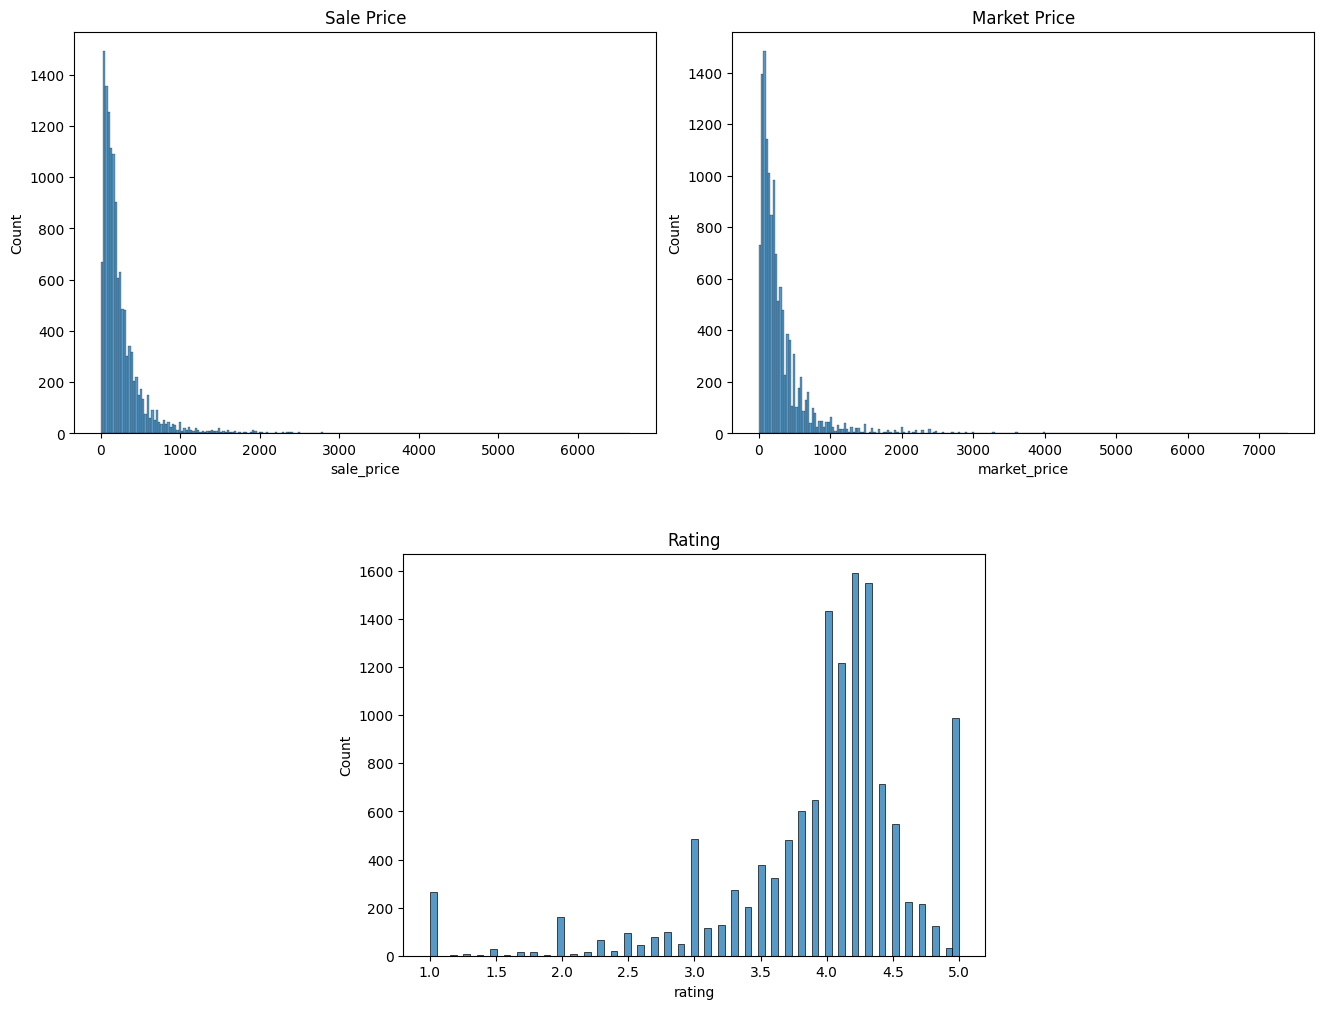

In [235]:
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(2, 4, hspace=0.3, wspace=0.3)

ax1 = fig.add_subplot(gs[0, 0:2])
sns.histplot(df_train['sale_price'], ax=ax1)
ax1.set_title('Sale Price')

ax2 = fig.add_subplot(gs[0, 2:4])
sns.histplot(df_train['market_price'], ax=ax2)
ax2.set_title('Market Price')

ax3 = fig.add_subplot(gs[1, 1:3])
sns.histplot(df_train['rating'], ax=ax3)
ax3.set_title('Rating')

plt.show()

In [236]:
df_train.nunique()

index           13250
product         11806
category            9
sub_category       76
brand            1762
sale_price       2029
market_price      895
type              353
rating             40
description     11136
dtype: int64

category ANALYSIS - STATISTICAL SIGNIFICANCE (sorted by normalized score)
                category  count     mean      std  median  significance_score  normalized_score
        Beauty & Hygiene   3804 3.928207 0.855132     4.1         3982.697625          1.000000
Foodgrains, Oil & Masala   1544 4.068782 0.440140     4.1         2858.516670          0.687873
  Snacks & Branded Foods   1735 3.989683 0.548220     4.1         2676.560419          0.637353
    Cleaning & Household   1480 3.973716 0.633826     4.1         2016.825548          0.454178
  Kitchen, Garden & Pets   1784 3.724552 0.859556     3.9         1859.193759          0.410412
    Gourmet & World Food   1672 3.977811 0.811714     4.1         1833.909221          0.403392
   Bakery, Cakes & Dairy    460 3.911957 0.508070     4.0          756.491273          0.104248
               Beverages    430 4.106744 0.556149     4.2          655.338938          0.076163
               Baby Care    341 3.986217 0.794957     4.2     

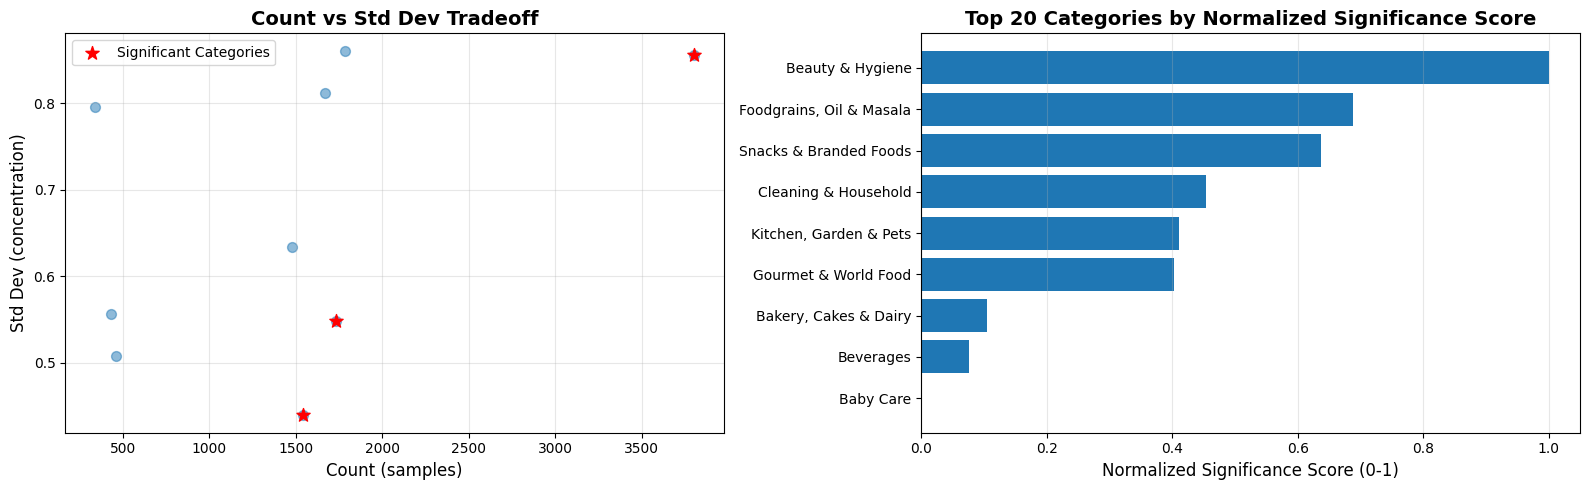

In [237]:
# Analyze category: std dev vs count - find the most statistically significant ones
category_analysis = df_train.groupby('category')['rating'].agg([
    ('count', 'count'),
    ('mean', 'mean'),
    ('std', 'std'),
    ('median', 'median')
]).reset_index()

# Create a raw significance score: count / std (higher count, lower std = higher score)
# +0.1 to avoid division by zero
category_analysis['significance_score'] = category_analysis['count'] / (category_analysis['std'] + 0.1)

# Normalize significance_score to [0, 1] using min-max scaling
min_s = category_analysis['significance_score'].min()
max_s = category_analysis['significance_score'].max()
if max_s - min_s > 0:
    category_analysis['normalized_score'] = (category_analysis['significance_score'] - min_s) / (max_s - min_s)
else:
    category_analysis['normalized_score'] = 0.0

# Sort by normalized score (higher = more significant)
category_analysis_sorted = category_analysis.sort_values('normalized_score', ascending=False)

print("="*80)
print("category ANALYSIS - STATISTICAL SIGNIFICANCE (sorted by normalized score)")
print("="*80)
print(category_analysis_sorted.head(20).to_string(index=False))
print("="*80)

# Find threshold: use top quartile on normalized score and a minimum count
threshold_count = 50  # At least 50 samples
threshold_score = category_analysis_sorted['normalized_score'].quantile(0.75)  # Top 25% by normalized score

significant_categories = category_analysis_sorted[
    (category_analysis_sorted['count'] >= threshold_count) & 
    (category_analysis_sorted['normalized_score'] >= threshold_score)
]['category'].tolist()

print(f"\n" + "="*80)
print(f"SIGNIFICANT CATEGORIES (count >= {threshold_count} AND in top 25% by normalized score)")
print("="*80)
print(f"Number of significant categories: {len(significant_categories)}")
print(f"Categories: {significant_categories}")
print("="*80)

# Visualize the tradeoff
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Scatter of count vs std
axes[0].scatter(category_analysis['count'], category_analysis['std'], alpha=0.5, s=50)
if len(significant_categories) > 0:
    sig_categories_data = category_analysis[category_analysis['category'].isin(significant_categories)]
    axes[0].scatter(sig_categories_data['count'], sig_categories_data['std'], 
                   color='red', s=100, label='Significant Categories', marker='*')
axes[0].set_xlabel('Count (samples)', fontsize=12)
axes[0].set_ylabel('Std Dev (concentration)', fontsize=12)
axes[0].set_title('Count vs Std Dev Tradeoff', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Top categories by normalized significance score
top_20 = category_analysis_sorted.head(20)
axes[1].barh(range(len(top_20)), top_20['normalized_score'].values)
axes[1].set_yticks(range(len(top_20)))
axes[1].set_yticklabels(top_20['category'].values)
axes[1].set_xlabel('Normalized Significance Score (0-1)', fontsize=12)
axes[1].set_title('Top 20 Categories by Normalized Significance Score', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

BRAND ANALYSIS - STATISTICAL SIGNIFICANCE (sorted by normalized score)
   brand  count     mean      std  median  significance_score  normalized_score
bb Royal    192 4.042708 0.131240    4.00          830.304773          1.000000
    Amul    114 4.057895 0.298045    4.15          286.399652          0.344394
 BB Home    124 4.105645 0.408508    4.20          243.850839          0.293107

SIGNIFICANT BRANDS (count >= 50 AND in top 25% by normalized score)
Number of significant brands: 25
Brands: ['bb Royal', 'Amul', 'BB Home', 'Britannia', 'Himalaya', '24 Mantra', 'Sunfeast', 'MTR', 'Keya', 'Nivea', 'Organic Tattva', 'Cello', 'Loreal Paris', 'DP', 'Khadi Natural', 'Princeware', 'Anjali', 'Colgate', 'Mamaearth', 'Himalayan Natives', 'BIOTIQUE', 'LaOpala', 'Iveo ', 'INATUR ', 'Nakoda']


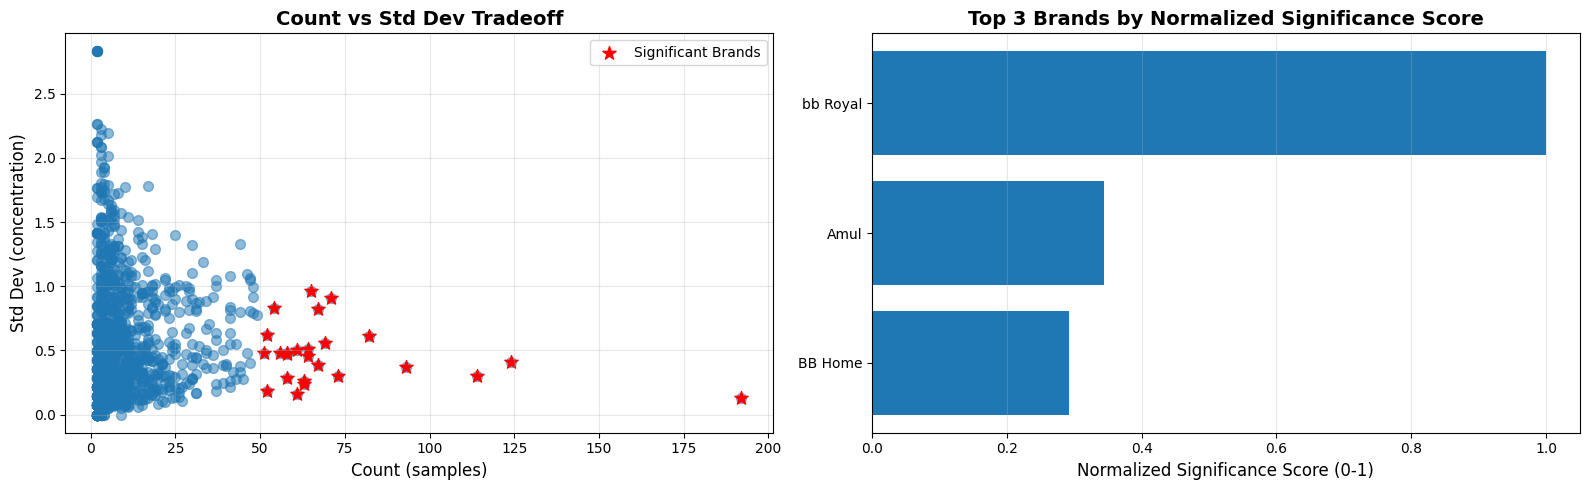

In [238]:
# Analyze brands: std dev vs count - find the most statistically significant ones
brand_analysis = df_train.groupby('brand')['rating'].agg([
    ('count', 'count'),
    ('mean', 'mean'),
    ('std', 'std'),
    ('median', 'median')
]).reset_index()

# Create a raw significance score: count / std (higher count, lower std = higher score)
brand_analysis['significance_score'] = brand_analysis['count'] / (brand_analysis['std'] + 0.1)  # +0.1 to avoid division by zero

# Normalize significance_score to [0, 1]
min_s = brand_analysis['significance_score'].min()
max_s = brand_analysis['significance_score'].max()
if max_s - min_s > 0:
    brand_analysis['normalized_score'] = (brand_analysis['significance_score'] - min_s) / (max_s - min_s)
else:
    brand_analysis['normalized_score'] = 0.0

# Sort by normalized score
brand_analysis_sorted = brand_analysis.sort_values('normalized_score', ascending=False)

print("="*80)
print("BRAND ANALYSIS - STATISTICAL SIGNIFICANCE (sorted by normalized score)")
print("="*80)
print(brand_analysis_sorted.head(3).to_string(index=False))
print("="*80)

# Find threshold: use top quartile on normalized score and a minimum count
threshold_count = 50  # At least 50 samples
threshold_score = brand_analysis_sorted['normalized_score'].quantile(0.75)  # Top 25%

significant_brands = brand_analysis_sorted[
    (brand_analysis_sorted['count'] >= threshold_count) & 
    (brand_analysis_sorted['normalized_score'] >= threshold_score)
]['brand'].tolist()

print(f"\n" + "="*80)
print(f"SIGNIFICANT BRANDS (count >= {threshold_count} AND in top 25% by normalized score)")
print("="*80)
print(f"Number of significant brands: {len(significant_brands)}")
print(f"Brands: {significant_brands}")
print("="*80)

# Visualize the tradeoff
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Scatter of count vs std
axes[0].scatter(brand_analysis['count'], brand_analysis['std'], alpha=0.5, s=50)
if len(significant_brands) > 0:
    sig_brands_data = brand_analysis[brand_analysis['brand'].isin(significant_brands)]
    axes[0].scatter(sig_brands_data['count'], 
                    sig_brands_data['std'], 
                   color='red', s=100, label='Significant Brands', marker='*')
axes[0].set_xlabel('Count (samples)', fontsize=12)
axes[0].set_ylabel('Std Dev (concentration)', fontsize=12)
axes[0].set_title('Count vs Std Dev Tradeoff', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Top brands by normalized significance score
top_3 = brand_analysis_sorted.head(3)
axes[1].barh(range(len(top_3)), top_3['normalized_score'].values)
axes[1].set_yticks(range(len(top_3)))
axes[1].set_yticklabels(top_3['brand'].values)
axes[1].set_xlabel('Normalized Significance Score (0-1)', fontsize=12)
axes[1].set_title('Top 3 Brands by Normalized Significance Score', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## Preprocessing

### Pipeline 1

In [239]:
# Define steps for numerical features
numeric_transformer = Pipeline(steps=[
    ('log_transform', FunctionTransformer(np.log1p, validate=True)),
    ('scaler', StandardScaler())
])

# Define steps for categorical features (Target Encoding)
categorical_transformer = TargetEncoder(smooth='auto') 

# Define steps for one-hot features
ohe_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, ['sale_price', 'market_price']),
        ('target_cat', categorical_transformer, ['brand', 'sub_category']),
        ('ohe_cat', ohe_transformer, ['category']) 
    ],
    remainder='drop'
)

# Now, apply to your data:
X_train_preprocessed_p1 = pd.DataFrame(preprocessor.fit_transform(X_train, y_train))
X_test_preprocessed_p1 = pd.DataFrame(preprocessor.transform(X_test))

### Feature engineering (classify in home/cleaning, beauty/health and food)

In [240]:
# Category organization into three groups
home_and_cleaning = ['Cleaning & Household', ' Kitchen, Garden & Pets']
beauty_and_health = ['Baby Care', 'Beauty & Hygiene', ]
food = ['Bakery, Cakes & Dairy', 'Beverages', 'Foodgrains, Oil & Masala', 
        'Gourmet & World Food', 'Snacks & Branded Foods']
in_bb_Royal = ['bb Royal']

In [241]:
# Create binary columns for category groups
def categorize_row(row):
    is_home_cleaning = 1 if row['category'] in home_and_cleaning else 0
    is_beauty_health = 1 if row['category'] in beauty_and_health else 0
    is_food = 1 if row['category'] in food else 0
    is_in_bb_Royal = 1 if row['brand'] in in_bb_Royal else 0
    return pd.Series([is_home_cleaning, is_beauty_health, is_food, is_in_bb_Royal])

# Apply to training and test data
df_train[['home_and_cleaning', 'beauty_and_health', 'food', 'is_in_bb_Royal']] = df_train.apply(categorize_row, axis=1)
df_test[['home_and_cleaning', 'beauty_and_health', 'food', 'is_in_bb_Royal']] = df_test.apply(categorize_row, axis=1)

# Also apply to test_no_target for consistency
test_no_target[['home_and_cleaning', 'beauty_and_health', 'food', 'is_in_bb_Royal']] = test_no_target.apply(categorize_row, axis=1)

# Remove original category and sub_category columns
df_train = df_train.drop(['category', 'sub_category', 'brand'], axis=1)
df_test = df_test.drop(['category', 'sub_category', 'brand'], axis=1)
test_no_target = test_no_target.drop(['category', 'sub_category', 'brand'], axis=1)

# Update X_train and X_test
X_train_art = df_train.drop('rating', axis=1)
y_train_art = df_train['rating']
X_test_art = df_test.drop('rating', axis=1)
y_test_art = df_test['rating']

### Pipeline 2 (numericals and all categories in home/cleaning, beauty/health and food)

In [242]:
# Define steps for numerical features
numeric_transformer = Pipeline(steps=[
    ('log_transform', FunctionTransformer(np.log1p, validate=True)),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, ['sale_price', 'market_price']),
        ('keep_as_is', 'passthrough', ['home_and_cleaning', 'beauty_and_health', 'food', 'is_in_bb_Royal']),
    ],
    remainder='drop'
)

# Now, apply to your data:
X_train_preprocessed_p2 = pd.DataFrame(preprocessor.fit_transform(X_train_art, y_train_art))
X_test_preprocessed_p2 = pd.DataFrame(preprocessor.transform(X_test_art))

### Pipeline 3 (Only Market and sale price)

In [248]:
# Define steps for numerical features
numeric_transformer = Pipeline(steps=[
    ('log_transform', FunctionTransformer(np.log1p, validate=True)),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, ['sale_price', 'market_price']),
      ],
    remainder='drop'
)

# Now, apply to your data:
X_train_preprocessed_p3 = pd.DataFrame(preprocessor.fit_transform(X_train, y_train))
X_test_preprocessed_p3 = pd.DataFrame(preprocessor.transform(X_test))

## Base model (mean rating)

In [244]:
y_preds = np.full(shape=df_test['rating'].shape, fill_value=df_train['rating'].mean())
y_test = df_test['rating']

In [245]:
#metrics
mae_base = mean_absolute_error(y_test, y_preds)
mse_base = mean_squared_error(y_test, y_preds)
r2_base = r2_score(y_test, y_preds)
rmse_base = np.sqrt(mse_base)


## Linear regression

In [254]:
LinGen1 = LinearRegression()
LinGen1.fit(X_train_preprocessed_p1, y_train)

y_pred_train_1 = LinGen1.predict(X_train_preprocessed_p1)
mse_train_1 = mean_squared_error(y_train, y_pred_train_1)
mae_train_1 = mean_absolute_error(y_train, y_pred_train_1)
r2_train_1 = r2_score(y_train, y_pred_train_1)

y_pred_test_1 = LinGen1.predict(X_test_preprocessed_p1)
mse_test_1 = mean_squared_error(y_test, y_pred_test_1)
mae_test_1 = mean_absolute_error(y_test, y_pred_test_1)
r2_test_1 = r2_score(y_test, y_pred_test_1)

In [260]:
# Model Comparison Summary Table
summary_data = {
    'Model': ['LinGen2', 'LinGen2','BaseModel'],
    'Dataset': ['Train', 'Test', 'Test'],
    'MSE': [mse_train_1, mse_test_1, mse_base],
    'MAE': [mae_train_1, mae_test_1, mae_base],
    'RMSE': [np.sqrt(mse_train_1), np.sqrt(mse_test_1), rmse_base],
    'R² Score': [r2_train_1, r2_test_1, r2_base]
}

summary_df = pd.DataFrame(summary_data)

print("="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)
print(summary_df.to_string(index=False))
print("="*60)

MODEL PERFORMANCE SUMMARY
    Model Dataset      MSE      MAE     RMSE      R² Score
  LinGen2   Train 0.495593 0.462996 0.703984  8.920401e-02
  LinGen2    Test 0.505262 0.463479 0.710818  8.296872e-02
BaseModel    Test 0.550976 0.505593 0.742278 -3.229992e-07


In [255]:
LinGen2 = LinearRegression()
LinGen2.fit(X_train_preprocessed_p2, y_train)

y_pred_train_2 = LinGen2.predict(X_train_preprocessed_p2)
mse_train_2 = mean_squared_error(y_train, y_pred_train_2)
mae_train_2 = mean_absolute_error(y_train, y_pred_train_2)
r2_train_2 = r2_score(y_train, y_pred_train_2)

y_pred_test_2 = LinGen2.predict(X_test_preprocessed_p2)
mse_test_2 = mean_squared_error(y_test, y_pred_test_2)
mae_test_2 = mean_absolute_error(y_test, y_pred_test_2)
r2_test_2 = r2_score(y_test, y_pred_test_2)


In [259]:
# Model Comparison Summary Table
summary_data = {
    'Model': ['LinGen2', 'LinGen2','BaseModel'],
    'Dataset': ['Train', 'Test', 'Test'],
    'MSE': [mse_train_2, mse_test_2, mse_base],
    'MAE': [mae_train_2, mae_test_2, mae_base],
    'RMSE': [np.sqrt(mse_train_2), np.sqrt(mse_test_2), rmse_base],
    'R² Score': [r2_train_2, r2_test_2, r2_base]
}

summary_df = pd.DataFrame(summary_data)

print("="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)
print(summary_df.to_string(index=False))
print("="*60)

MODEL PERFORMANCE SUMMARY
    Model Dataset      MSE      MAE     RMSE      R² Score
  LinGen2   Train 0.534687 0.499265 0.731223  1.735825e-02
  LinGen2    Test 0.543873 0.499086 0.737478  1.289085e-02
BaseModel    Test 0.550976 0.505593 0.742278 -3.229992e-07


In [256]:
LinGen3 = LinearRegression()
LinGen3.fit(X_train_preprocessed_p3, y_train)

y_pred_train_3 = LinGen3.predict(X_train_preprocessed_p3)
mse_train_3 = mean_squared_error(y_train, y_pred_train_3)
mae_train_3 = mean_absolute_error(y_train, y_pred_train_3)
r2_train_3 = r2_score(y_train, y_pred_train_3)

y_pred_test_3 = LinGen3.predict(X_test_preprocessed_p3)
mse_test_3 = mean_squared_error(y_test, y_pred_test_3)
mae_test_3 = mean_absolute_error(y_test, y_pred_test_3)
r2_test_3 = r2_score(y_test, y_pred_test_3)

In [258]:
# Model Comparison Summary Table
summary_data = {
    'Model': ['LinGen3', 'LinGen3','BaseModel'],
    'Dataset': ['Train', 'Test', 'Test'],
    'MSE': [mse_train_3, mse_test_3, mse_base],
    'MAE': [mae_train_3, mae_test_3, mae_base],
    'RMSE': [np.sqrt(mse_train_3), np.sqrt(mse_test_3), rmse_base],
    'R² Score': [r2_train_3, r2_test_3, r2_base]
}

summary_df = pd.DataFrame(summary_data)

print("="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)
print(summary_df.to_string(index=False))
print("="*60)

MODEL PERFORMANCE SUMMARY
    Model Dataset      MSE      MAE     RMSE      R² Score
  LinGen3   Train 0.534687 0.499265 0.731223  1.735825e-02
  LinGen3    Test 0.543873 0.499086 0.737478  1.289085e-02
BaseModel    Test 0.550976 0.505593 0.742278 -3.229992e-07
